# This is a recreation of the work in: Model Predictive Control for integrated lateral stability, traction/braking control, and rollover prevention of electric vehicles 
By: Mansour Ataei, Amir Khajepour & Soo Jeon

In [2]:
# Run this cell only if you are using Google Colab. 

# install required dependencies
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install -q pyomo
  !pip install mosek
  !apt-get install -y -qq glpk-utils
  !apt-get install -y -qq coinor-cbc
  !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64
  !pip install ttictoc

     |████████████████████████████████| 11.1 MB 14.5 MB/s 
     |████████████████████████████████| 49 kB 1.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.4 MB 4.9 MB/s 
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-1_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-1

The Dugoff model for a typical tire is Dugoff 1970, Wong, 1978

$$
\begin{aligned}
&F_x=-\frac{C_s s}{1-s} f(\lambda) \\
&F_y=-\frac{C_\alpha \tan \alpha}{1-s} f(\lambda)
\end{aligned}
$$
\\
$$
\begin{aligned}
&\lambda=\frac{\mu F_z\left(1-\epsilon v \sqrt{s^2+\tan ^2 \alpha}\right)(1-s)}{2 \overline{c_s^2 s^2+C_\alpha^2 \tan ^2 \alpha}} \\
\\
&f(\lambda)= \begin{cases}X(2-\lambda) & \text { for } \lambda<1 \\
1 & \text { for } \lambda>1\end{cases}
\end{aligned}
$$

$F_x=$ longitudinal force \\
$F_y=$ side force

$\mathrm{s}=$ longitudinal slip \\
$\alpha=$ tire slip angle \\
$C_s=$ cornering stiffness \\
$C_\alpha=$ longitudinal stiffens \\
$F_z=$ vertical load \\
$v=$ vehicle speed \\
$\mu=$ coefficient of road adhesion \\
$\epsilon=$ adhesion reduction coefficient

In this section, we use $\alpha$ to denote the tire slip angle


============================================================================

MODEL USED

given by (Guntur and Sankar, 1980, Dugoff, 1969)
$$
F_x=C_\sigma \frac{\sigma_x}{1+\sigma_x} f(\lambda)
$$
and the lateral tire force is given by $\quad F_y=C_\alpha \frac{\tan (\alpha)}{1+\sigma_x} f(\lambda)$
where $\lambda$ is given by
$$
\lambda=\frac{\mu F_z\left(1+\sigma_x\right)}{2\left\{\left(C_\sigma \sigma_x\right)^2+\left(C_\alpha \tan (\alpha)\right)^2\right\}^{1 / 2}}
$$
and
$f(\lambda)=(2-\lambda) \lambda$ if $\lambda<1$
$f(\lambda)=1$ if $\lambda \geq 1$
$F_z$ is the vertical force on the tire while $\mu$ is the tire-road friction coefficient.




In [3]:
def DugoffLinearizer(slip_angle,slip_ratio, ca, cs, mu, Fz):
  lamb_bar = mu*Fz*(1+slip_ratio)/(2*((cs*slip_ratio)**2+(ca*slip_angle)**2)**0.5)
  
  if slip_angle !=0 or slip_ratio !=0:
    if lamb_bar < 1: 
      fbar = lamb_bar*(2-lamb_bar)
      c_bar = (Fz*ca*mu)/(2*(slip_angle**2*ca**2 + cs**2*slip_ratio**2)**(1/2)) - (Fz*slip_angle**2*ca**3*mu)/(2*(slip_angle**2*ca**2 + cs**2*slip_ratio**2)**(3/2))
      
    else:
      fbar = 1
      c_bar = ca/(1+slip_ratio)
    Fy_bar= ca*slip_angle*fbar/(1+slip_ratio)
    c_bar = c_bar.item()
    Fy_bar = Fy_bar.item()
                                                                 
  else:
    fbar = 1
    c_bar = ca.item()
    Fy_bar = 0

  return Fy_bar, c_bar, slip_angle

In [4]:
import numpy as np
from scipy.linalg import block_diag
import sympy as sym
import pyomo.environ as pyo

**Optimal_Control_partI.pdf**
2. Linear Quadratic Optimal Control
2.1 Batch Approach Solution

Starting with $x_0=x(0)$, we have $x_1=A x(0)+B u_0$, and $x_2=A x_1+B u_1=A^2 x(0)+A B u_0+B u_1$, by substitution for $x_1$, and so on. Continuing up to $x_N$ we obtain:
$$
\left[\begin{array}{c}
x_0 \\
x_1 \\
\vdots \\
\vdots \\
x_N
\end{array}\right]=\left[\begin{array}{c}
I \\
A \\
\vdots \\
\vdots \\
A^N
\end{array}\right] x(0)+\left[\begin{array}{cccc}
0 & \cdots & \cdots & 0 \\
B & 0 & \cdots & 0 \\
A B & B & \cdots & 0 \\
\vdots & \ddots & \ddots & 0 \\
A^{N-1} B & \cdots & A B & B
\end{array}\right]\left[\begin{array}{c}
u_0 \\
u_1 \\
\vdots \\
\vdots \\
u_{N-1}
\end{array}\right]
$$

The equation above can be represented as
$$
\mathcal{X} \triangleq \mathcal{S}^x x(0)+\mathcal{S}^u U_0
$$

In [5]:
def Sx_Su_Sw_Sd(A, B, E, D, N):
  nX = np.size(A,0)
  nU = np.size(B,1)
  nE = np.size(E,1)

  Sx = np.eye(nX)
  A_tmp = A
  for i in range(N):
      Sx = np.vstack((Sx, A_tmp))
      A_tmp = A_tmp @ A
      
  SxB = Sx @ B
  Su = np.zeros((nX*(N+1),nU*N))
  
  for j in range(N):
      Su_tmp = np.vstack((np.zeros((nX, nU)), SxB[:-nX,:]))
      Su[:, j:j+8] = Su_tmp.reshape(Su_tmp.shape[0],8 )
      SxB = Su_tmp

  SxE = Sx @ E
  Sw = np.zeros((nX*(N+1),nE*N))
  for k in range(N):
      Sw_tmp = np.vstack((np.zeros((nX, nE)), SxE[:-nX,:]))
      Sw[:, j:j+8] = Sw_tmp.reshape(Sw_tmp.shape[0],8 )
      SxE = Sw_tmp

  Sd = np.zeros((nX,1))
  D_tmp = D
  for i in range(N):
      Sd = np.vstack((Sd, D_tmp))
      D_tmp = A @ D_tmp
  return Sx, Su, Sw, Sd

In [6]:
from pyomo.opt.results import solver
def CFTOC_frompaper(slip_angle,slip_ratio,ca,cs,mu,fz0,u,reff,delta,tf,tr,lf,lr,ms,hs,hr,hu,kphi,g,ixx,m,cphi,iw,x0,delta_d,kus_d,muy,mux,alphamax,lambmax,RIc,W0,N,Qmax,Qmin,deltamax,fy0):
  #Qmin: add this input
  #deltamax: add this input
  nX = 8
  nU = 8
  x0.reshape(8,1)
  
  # Corner forces
  fy1, ca1, a1 = DugoffLinearizer(slip_angle[0],slip_ratio[0], ca[0], cs[0], mux, fz0[0])
  fy2, ca2, a2 = DugoffLinearizer(slip_angle[1],slip_ratio[1], ca[1], cs[1], mux, fz0[1])
  fy3, ca3, a3 = DugoffLinearizer(slip_angle[2],slip_ratio[2], ca[2], cs[2], mux, fz0[2])
  fy4, ca4, a4 = DugoffLinearizer(slip_angle[3],slip_ratio[3], ca[3], cs[3], mux, fz0[3])


  fx0 = np.zeros((4,1))
  for i in range(len(fz0)):
    fx0[i] = mux*fz0[i]*np.sqrt(1-(fy0[i]/(muy*fz0[i]))**2)
  fx0=fx0.reshape(4,)
  B11 = np.array([[0,0,0,0], [-ca1/u, -lf*ca1/u, 0, 0]])
  B21 = np.array([[1/reff, 0],[0, ca1]])
  D11 = np.array ([0, fy1-ca1*a1])

  B12 = np.array([[0,0,0,0], [-ca2/u, -lf*ca2/u, 0, 0]])
  B22 = np.array([[1/reff, 0],[0, ca2]])
  D12 = np.array ([0, fy2-ca2*a2])

  B13 = np.array([[0,0,0,0], [-ca3/u, lr*ca3/u, 0, 0]])
  B23 = np.array([[1/reff, 0],[0, ca3]])
  D13 = np.array ([0, fy3-ca3*a3])

  B14 = np.array([[0,0,0,0], [-ca4/u, lr*ca4/u, 0, 0]])
  B24 = np.array([[1/reff, 0],[0, ca4]])
  D14 = np.array ([0, fy4-ca4*a4])

  # Load Actuator Reconfiguration Matrix
  Tw1 = np.array([[1,0],[0,0]])
  Tw2 = np.array([[1,0],[0,0]])
  Tw3 = np.array([[1,0],[0,0]])
  Tw4 = np.array([[1,0],[0,0]])

  #Reconfiguration (Mapping) Matricies: Delta1 input
  Lw1 = np.array ([[np.cos(delta[0]), -np.sin(delta[0])],[np.sin(delta[0]), np.cos(delta[0])]])
  Lw2 = np.array ([[np.cos(delta[1]), -np.sin(delta[1])],[np.sin(delta[1]), np.cos(delta[1])]])
  Lw3 = np.array ([[np.cos(delta[2]), -np.sin(delta[2])],[np.sin(delta[2]), np.cos(delta[2])]])
  Lw4 = np.array ([[np.cos(delta[3]), -np.sin(delta[3])],[np.sin(delta[3]), np.cos(delta[3])]])

  #Mapping Matrix from corner to CG forces
  Lc = np.array([[1,0,1,0,1,0,1,0],[0,1,0,1,0,1,0,1], [-tf/2,lf,tf/2,lf,-tr/2,-lr,tr/2,-lr]])

  #Vehicle Body Dynamics
  Af = [[0,-u, ms*hs*(kphi-ms*g*hs)/(m*ixx+ms**2*hs**2), ms*hs*cphi/(m*ixx-ms**2*hs**2)], [0,0,0,0],[0,0,0,0],[0,0,-m*(kphi-ms*g*hs)/(m*ixx-ms**2*hs**2), -m*cphi/(m*ixx-ms**2*hs**2)]]
  Bf = [[0,ixx/(m*ixx-ms**2*hs**2),0], [0,0,1/Izz],[0,0,0], [0,ms*hs/(m*ixx-ms**2*hs**2),0]]

  #Compilation
  B1 = np.hstack((B11.T, B12.T, B13.T, B14.T)).T
  B2 = block_diag(B21,B22,B23,B24)
  D1 = np.hstack((D11,D12,D13,D14)).T
  Tw = block_diag(Tw1,Tw2,Tw3,Tw4)
  Lw = block_diag(Lw1,Lw2,Lw3,Lw4)

  #Xb_dot = AXb +EW +BU +D
  Ab = Af+Bf@Lc@Lw@B1
  Eb = Bf@Lc@Lw@B2
  Bb = Bf@Lc@Lw@B2@Tw
  Db = Bf@Lc@Lw@D1

  #wheel:
  Aw = np.zeros((4,4))
  Ew = np.zeros((4,8))
  Bw = 1/iw * np.array([[1,0,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,0,1,0]])
  Dw = np.zeros((1,4))

  A = block_diag(Ab, Aw)
  E = np.hstack((Eb.T, Ew.T)).T
  B = np.hstack((Bb.T, Bw.T)).T
  D = np.hstack((Db.T, Dw[0].T)).T 
  D = D.reshape(8,)
  


  A = np.eye(8)+Ts*A
  E = E*Ts
  B = B*Ts
  D = D *Ts
  
################################################################################
  ## CONTROL OBJECTIVES ##
  # Yaw   Rate
  rb = u*delta_d/(l+kus_d*u**2)
  rmax = muy*g/u 
  rd = np.sign(delta_d)*np.min([np.abs(rb), rmax])

  # Lateral Stability

  # Rollover Prevention
  C1 = 4/m/g/(tf+tr)*(kphi*(1+(ms*hr+mu*hu)/(ms*hs))-(ms*hr+mu*hu)*g)
  C2 = 2*cphi/(m*T*g)*(1+(ms*hr+mu*hu)/(ms*hs))
  # RI = C1*x[2]+C2*x[3]
  #Impose rollover index contraint

  wub = np.zeros((4,1))
  wlb =np.zeros((4,1))
  Rw = reff
  #Wheel spin constraint:
  wub[0] = u/Rw+lambmax*np.max([u/Rw, x0[4]])
  wub[1] = u/Rw+lambmax*np.max([u/Rw, x0[5]])
  wub[2] = u/Rw+lambmax*np.max([u/Rw, x0[6]])
  wub[3] = u/Rw+lambmax*np.max([u/Rw, x0[7]])
  wub = wub.reshape(4,)
  wlb[0] = u/Rw-lambmax*np.max([u/Rw, x0[4]])
  wlb[1] = u/Rw-lambmax*np.max([u/Rw, x0[5]])
  wlb[2] = u/Rw-lambmax*np.max([u/Rw, x0[6]])
  wlb[3] = u/Rw-lambmax*np.max([u/Rw, x0[7]])
  wlb = wlb.reshape(4,)

  xd = np.array([0,rd,0,0,u/reff,u/reff,u/reff,u/reff])
  Q = np.eye(8)
  Q[1,1] = 5000000
  R = np.eye(8)
  
  model = pyo.ConcreteModel()
  model.tidx = pyo.Set(initialize=range(0, N+1))
  model.xidx = pyo.Set(initialize=range(0, nX))
  model.uidx = pyo.Set(initialize=range(0, nU))

  model.x = pyo.Var(model.xidx, model.tidx)
  model.u = pyo.Var(model.uidx, model.tidx)
  model.xd = xd
  model.Q = Q
  model.R = R
  model.N = N
  model.A = A
  model.B = B
  model.E = E
  model.D = D
  model.W0 = W0
  #Objective:
  def objective_rule(model):
      costX = 0.0
      costU = 0.0
      costTerminal = 0.0
      for t in model.tidx:
          for i in model.xidx:
              for j in model.xidx:
                  if t < model.N:
                      costX += (model.x[i, t]-model.xd[i]) * model.Q[i, j] * (model.x[j, t]-model.xd[j]) 
      for t in model.tidx:
          for i in model.uidx:
              for j in model.uidx:
                  if t < (model.N - 1):
                      costU += model.u[i, t] * model.R[i, j] * model.u[j, t]
      return costX + costU
  model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)

  model.constraint1 = pyo.Constraint(model.tidx, rule=lambda model, t: ((C1*model.x[2, t])+(C2*model.x[3, t])) <= RIc
                                     if t <= N else pyo.Constraint.Skip) 
  model.constraint2 = pyo.Constraint(model.tidx, rule=lambda model, t: ((C1*model.x[2, t])+(C2*model.x[3, t])) >= -RIc
                                     if t <= N else pyo.Constraint.Skip) 
  model.constraint3 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[1, t] <= rmax
                                     if t <= N else pyo.Constraint.Skip) 
  model.constraint4 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[1, t] >= -rmax
                                     if t <= N else pyo.Constraint.Skip)

  model.constraint5 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[4, t] <= wub[0]
                                     if t <= N else pyo.Constraint.Skip)
  model.constraint6 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[5, t] <= wub[1]
                                     if t <= N else pyo.Constraint.Skip)
  model.constraint7 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[6, t] <= wub[2]
                                     if t <= N else pyo.Constraint.Skip)
  model.constraint8 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[7, t] <= wub[3]
                                     if t <= N else pyo.Constraint.Skip)
  model.constraint9 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[4, t] >= wlb[0]
                                     if t <= N else pyo.Constraint.Skip)
  model.constraint10 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[5, t] >= wlb[1]
                                      if t <= N else pyo.Constraint.Skip)
  model.constraint11 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[6, t] >= wlb[2]
                                      if t <= N else pyo.Constraint.Skip)
  model.constraint12 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[7, t] >= wlb[3]
                                      if t <= N else pyo.Constraint.Skip)
  model.constraint13 = pyo.Constraint(model.tidx, rule=lambda model, t: (-model.x[0, t]/u)+(lr*model.x[1, t]/u) <= alphamax
                                      if t <= N else pyo.Constraint.Skip) 
  model.constraint14 = pyo.Constraint(model.tidx, rule=lambda model, t: (-model.x[0, t]/u)+(lr*model.x[1, t]/u) >= -alphamax
                                      if t <= N else pyo.Constraint.Skip) 
  #Qi Constraints
  model.constraint15 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] <= Qmax - W0[0]
                                   if t < N else pyo.Constraint.Skip)
  model.constraint16 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] >= Qmin - W0[0]
                                   if t < N else pyo.Constraint.Skip)
  model.constraint17 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[2, t] <= Qmax - W0[2]
                                   if t < N else pyo.Constraint.Skip)
  model.constraint18 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[2, t] >= Qmin - W0[2]
                                   if t < N else pyo.Constraint.Skip)
  model.constraint19 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[4, t] <= Qmax - W0[4]
                                   if t < N else pyo.Constraint.Skip)
  model.constraint20 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[4, t] >= Qmin - W0[4]
                                   if t < N else pyo.Constraint.Skip)
  model.constraint21 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[6, t] <= Qmax - W0[6]
                                   if t < N else pyo.Constraint.Skip)
  model.constraint22 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[6, t] >= Qmin - W0[6]
                                   if t < N else pyo.Constraint.Skip)
  #fx0 constraints
  model.constraint23 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] <= fx0[0]-W0[0]
                                      if t < N else pyo.Constraint.Skip)
  model.constraint24 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[2, t] <= fx0[1]-W0[2]
                                      if t < N else pyo.Constraint.Skip)
  model.constraint25 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[4, t] <= fx0[2]-W0[4]
                                      if t < N else pyo.Constraint.Skip)
  model.constraint26 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[6, t] <= fx0[3]-W0[6]
                                      if t < N else pyo.Constraint.Skip)
  model.constraint27 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] >= -fx0[0]-W0[0]
                                      if t < N else pyo.Constraint.Skip)
  model.constraint28 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[2, t] >= -fx0[1]-W0[2]
                                      if t < N else pyo.Constraint.Skip)
  model.constraint29 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[4, t] >= -fx0[2]-W0[4]
                                      if t < N else pyo.Constraint.Skip)
  model.constraint30 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[6, t] >= -fx0[3]-W0[6]
                                      if t < N else pyo.Constraint.Skip)
  
  #delta_i constraints:
  model.constraint31 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t] <= deltamax - W0[1]
                                   if t < N else pyo.Constraint.Skip)

  model.constraint32 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t] >= -deltamax - W0[1]
                                   if t < N else pyo.Constraint.Skip)

  model.constraint33 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[3, t] <= deltamax - W0[3]
                                   if t < N else pyo.Constraint.Skip)

  model.constraint34 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[3, t] >= -deltamax - W0[3]
                                   if t < N else pyo.Constraint.Skip)

  model.constraint35 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[5, t] <= deltamax - W0[5]
                                   if t < N else pyo.Constraint.Skip)

  model.constraint36 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[5, t] >= -deltamax - W0[5]
                                   if t < N else pyo.Constraint.Skip)

  model.constraint37 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[7, t] <= deltamax - W0[7]
                                   if t < N else pyo.Constraint.Skip)

  model.constraint38 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[7, t] >= -deltamax - W0[7]
                                   if t < N else pyo.Constraint.Skip)
  
  model.constraint39 = pyo.Constraint(model.xidx, rule = lambda model, i: model.x[i,0] == x0[i])
  #model.constraint41 = pyo.Constraint(model.xidx, rule = lambda model, i: model.x[i,N] == xd[i])
  
  def eq_const_rule(model,i,t):
    return model.x[i,t+1]-(sum(model.A[i,j]*model.x[j,t] for j in model.xidx)+ sum(model.B[i,j] * model.u[j,t] for j in model.uidx)+sum(model.E[i,j]*model.W0[j] for j in model.uidx)+ model.D[i]) == 0 if t < model.N else pyo.Constraint.Skip
  
  model.constraint40 = pyo.Constraint(model.xidx, model.tidx, rule = eq_const_rule)
  results = pyo.SolverFactory('ipopt').solve(model).write()
  
  '''
  model.constraint42 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[7, t] == -deltamax - W0[7]
                                   if t < N else pyo.Constraint.Skip)
  '''

  # Plotting
  # plot results
  x1 = [pyo.value(model.x[0,0])]
  x2 = [pyo.value(model.x[1,0])]
  x3 = [pyo.value(model.x[2,0])]
  x4 = [pyo.value(model.x[3,0])]
  x5 = [pyo.value(model.x[4,0])]
  x6 = [pyo.value(model.x[5,0])]
  x7 = [pyo.value(model.x[6,0])]
  x8 = [pyo.value(model.x[7,0])]
  u1 = [pyo.value(model.u[0,0])]
  u2 = [pyo.value(model.u[1,0])]
  u3 = [pyo.value(model.u[2,0])]
  u4 = [pyo.value(model.u[3,0])]
  u5 = [pyo.value(model.u[4,0])]
  u6 = [pyo.value(model.u[5,0])]
  u7 = [pyo.value(model.u[6,0])]
  u8 = [pyo.value(model.u[7,0])]

  for t in model.tidx:
      if t < N:
          x1.append(pyo.value(model.x[0,t+1]))
          x2.append(pyo.value(model.x[1,t+1]))
          x3.append(pyo.value(model.x[2,t+1]))
          x4.append(pyo.value(model.x[3,t+1]))
          x5.append(pyo.value(model.x[4,t+1]))
          x6.append(pyo.value(model.x[5,t+1]))
          x7.append(pyo.value(model.x[6,t+1]))
          x8.append(pyo.value(model.x[7,t+1]))
      if t < N-1:
          u1.append(pyo.value(model.u[0,t+1]))
          u2.append(pyo.value(model.u[1,t+1]))
          u3.append(pyo.value(model.u[2,t+1]))
          u4.append(pyo.value(model.u[3,t+1]))
          u5.append(pyo.value(model.u[4,t+1]))
          u6.append(pyo.value(model.u[5,t+1]))
          u7.append(pyo.value(model.u[6,t+1]))
          u8.append(pyo.value(model.u[7,t+1]))


  tgrid = np.arange(0,N+1)*Ts
  uOpt = np.vstack((u1,u2,u3,u4,u5,u6,u7,u8))
  xOpt = np.vstack((x1,x2,x3,x4,x5,x6,x7,x8))
  JOpt = pyo.value(model.cost)

  return xOpt, uOpt, JOpt

In [7]:
#Model Parameters from 
ms = 1590
mu = 270
m = ms+mu
T = 1.575 
tf = T
tr = T
hcg = 0.72
l = 2.95
lf = 1.18
lr = 1.77
ixx = 894.4
Izz = 2687.1
hs = 0.57 
hu = 0.2
hr = 0.15
kphi = 189506
cphi = 6364
reff = 0.393
iw = 1.1
g = 9.81

#Case 1
mux = 1
muy = 1
u = 80/3.6
N = 10
Ts = 0.1
lambmax= 0.1
alphamax = 6/180*np.pi
Qmax = 1600
Qmin = - Qmax
deltamax = 1
RIc = 0.7

C1 = 4/m/g/(tf+tr)*(kphi*(1+(ms*hr+mu*hu)/(ms*hs))-(ms*hr+mu*hu)*g)
C2 = 2*cphi/(m*T*g)*(1+(ms*hr+mu*hu)/(ms*hs))

kus_d = 0.4 #####

delta_d = 0.15####
cs = 80000*np.ones((4,1)) ####
ca = 47275*np.ones((4,1)) #####
delta = [0,0,0,0]
x0 = np.array([0,0,0,0,53,53,53,53])
slip_ratio = [0.1,0.1,0.1,0.1]
for i in range(4):
  slip_ratio[i] = (reff*x0[4+i]-u)/(reff*x0[4+i])
slip_angle = [0,0,0,0]
fz0 = m*g/4*np.ones((4,1))
W0 = [1000,0,1000,0,1000,0,
      1000,0]
fy0 = np.zeros((4,1))
M = 250

rb = u*delta_d/(l+kus_d*u**2)
rmax = muy*g/u 
rd = np.sign(delta_d)*np.min([np.abs(rb), rmax])

yawRate = np.array([])
rolloverIndex = np.array([])
positionXD = np.array([])
lateralVelocity = np.array([])
wheelSpeed1 = np.array([])
wheelSpeed2 = np.array([])
wheelSpeed3 = np.array([])
wheelSpeed4 = np.array([])
deltaQ1 = np.array([])
deltaQ2 = np.array([])
deltaQ3 = np.array([])
deltaQ4 = np.array([])
total_change_in_torque = 0
for t in range(M):
  xopt, uopt, jopt = CFTOC_frompaper(slip_angle,slip_ratio,ca,cs,mu,fz0,u,reff,delta,tf,tr,lf,lr,ms,hs,hr,hu,kphi,g,ixx,m,cphi,iw,x0,delta_d,kus_d,muy,mux,alphamax,lambmax,RIc,W0,N,Qmax,Qmin,deltamax,fy0)
  x0 = xopt[:,1]
  u0 = uopt[:,0]

  # plot
  # RI vs. time at every time step overlay RIc
  # Wheel torque
  # yaw rate vs. time and overlay desired yaw rate r(d)
  
  RI = C1*x0[2]+C2*x0[3]

  yawRate = np.append(yawRate, x0[1])
  lateralVelocity = np.append(lateralVelocity, x0[0])
  rolloverIndex = np.append(rolloverIndex, RI)
  wheelSpeed1 = np.append(wheelSpeed1, x0[4])
  wheelSpeed2 = np.append(wheelSpeed2, x0[5])
  wheelSpeed3 = np.append(wheelSpeed3, x0[6])
  wheelSpeed4 = np.append(wheelSpeed4, x0[7])



  slip_angle_1 = W0[1] - (x0[0]+lf*x0[1])/u*np.ones((2,))
  slip_angle_2 = (x0[0]-lr*x0[1])/u*np.ones((2,))
  slip_angle = np.hstack((slip_angle_1,slip_angle_2))
  for i in range(4):
    slip_ratio[i] = (reff*x0[4+i]-u)/(reff*x0[4+i])
  total_change_in_torque = total_change_in_torque + u0
  W0 = W0+ u0
  deltaQ1 = np.append(deltaQ1, total_change_in_torque[0])
  deltaQ2 = np.append(deltaQ2, total_change_in_torque[2])
  deltaQ3 = np.append(deltaQ3, total_change_in_torque[4])
  deltaQ4 = np.append(deltaQ4, total_change_in_torque[6])
  fz1 = m*g/2 -kphi/2/tf*x0[2]-cphi/2/tf*x0[3]
  fz2 = m*g/2 +kphi/2/tf*x0[2]+cphi/2/tf*x0[3]
  fz3 = m*g/2 -kphi/2/tr*x0[2]-cphi/2/tr*x0[3]
  fz4 = m*g/2 +kphi/2/tr*x0[2]+cphi/2/tr*x0[3]
  fz0 = np.array([fz1,fz2,fz3,fz4])/2

  fy1= ca[0]*(u0[1]- slip_angle_1[0])
  fy2= ca[0]*(u0[1]- slip_angle_1[1])
  fy3= ca[0]*(- slip_angle_2[0])
  fy4= ca[0]*(- slip_angle_2[1])
  fy0 = np.array([fy1,fy2,fy3,fy4])
  print(x0)
  print(W0)


Streaming output truncated to the last 5000 lines.
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.07384061813354492
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
[-2.78303524e-02  1.31906108e-02  1.22479615e-23  1.41480172e-02
  5.44917275e+01  5.85832061e+01  5.44917275e+01  5.85832061e+01]
[1016.40900275    0.         1061.41526717    0.         1016.40900275
    0.         1061.41526717    0.        ]
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------

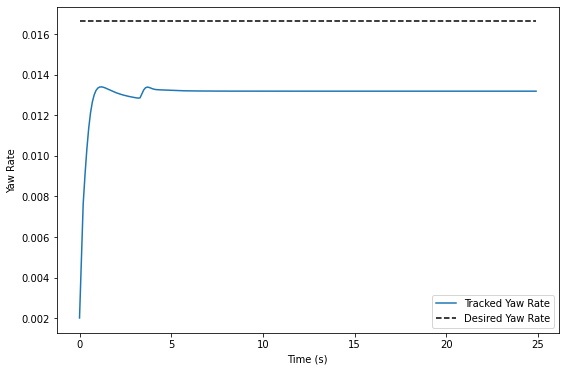

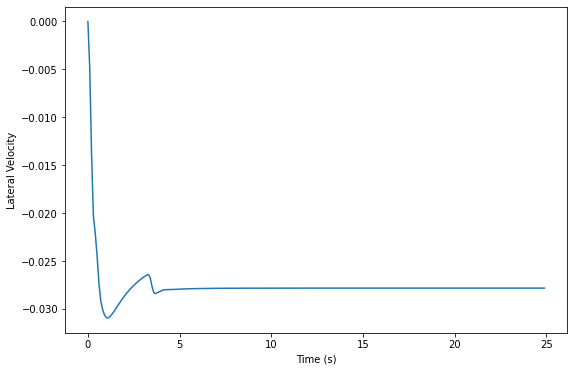

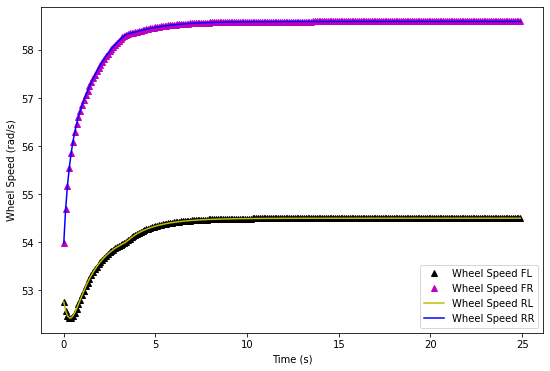

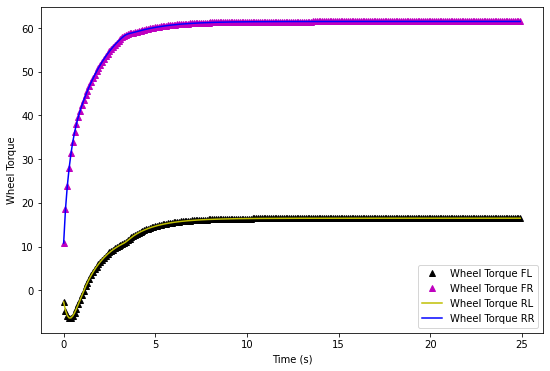

In [10]:
import matplotlib.pyplot as plt

time = np.arange(0, M*Ts, 0.1)
plt.figure(1, figsize=(9, 6))
plt.plot(time, yawRate, label = 'Tracked Yaw Rate')
rdArr = np.full(shape=250, fill_value=rd)
plt.plot(time, rdArr, 'k--', label = 'Desired Yaw Rate')
plt.ylabel('Yaw Rate')
plt.xlabel('Time (s)')
plt.legend()

plt.figure(2, figsize=(9, 6))
plt.plot(time, lateralVelocity)
plt.ylabel('Lateral Velocity')
plt.xlabel('Time (s)')

plt.figure(4, figsize=(9, 6))
plt.plot(time, wheelSpeed1, 'k^', label = 'Wheel Speed FL')
plt.plot(time, wheelSpeed2, 'm^', label = 'Wheel Speed FR')
plt.ylabel('Wheel Speed (rad/s)')
plt.plot(time, wheelSpeed3, 'y', label = 'Wheel Speed RL')
plt.xlabel('Time (s)')
plt.plot(time, wheelSpeed4, 'b', label = 'Wheel Speed RR')
plt.legend()
plt.show()

plt.figure(5, figsize=(9, 6))
plt.plot(time, deltaQ1, 'k^', label = "Wheel Torque FL")
plt.ylabel('Wheel Torque')
plt.plot(time, deltaQ2, 'm^', label = "Wheel Torque FR")
plt.plot(time, deltaQ3, 'y', label = "Wheel Torque RL")
plt.plot(time, deltaQ4, 'b', label = "Wheel Torque RR")
plt.xlabel('Time (s)')
plt.legend()
plt.show()